In [ ]:
from tifffile import imread,imwrite
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pywt

torch.cuda.empty_cache()
video = torch.from_numpy(imread('pooled1.tif').astype(np.float32)).to('cuda')
shape=video.shape
print(shape)

torch.Size([1349, 270, 360])


In [ ]:
# Permute tensor to bring the first dimension to the last (for conv1d)
video = video.permute(2, 1, 0)  # Shape: [270*360,1, 1349]

# Create a Gaussian kernel (time)
def gaussian_kernel1d(kernel_size=5, sigma=1.0):
    x = torch.arange(kernel_size) - kernel_size // 2
    kernel = torch.exp(-0.5 * (x / sigma) ** 2)
    kernel /= kernel.sum()  # Normalize
    return kernel.view(1, 1, -1)  # Shape: (out_channels, in_channels, kernel_size)

# Denoising kernel
kernel = gaussian_kernel1d(kernel_size=11, sigma=4.0).to('cuda')
kernel = kernel.repeat(shape[1], 1, 1)  # (C, 1, K)
video = F.pad(video, pad=(5,5), mode='reflect')
video = F.conv1d(video, kernel, groups=shape[1])  # Padding maintains size

video = video.permute(2, 1, 0)
shape=video.shape
print(shape)

torch.Size([1349, 270, 360])


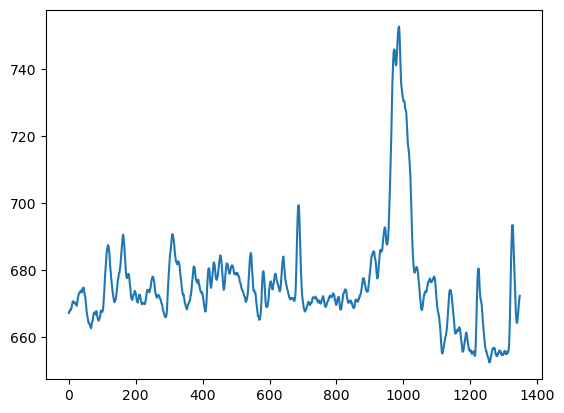

In [ ]:
plt.plot(video[:,120,240].cpu().numpy())

In [ ]:
video = video.to('cpu').numpy()

In [ ]:
'''
# Comparing filterring effects of different wavelets

wavelets = ['bior6.8','coif8','db8','dmey','sym8']
levels=[5,5,5,5,2]
frame=270
plt.figure(figsize=(20,30))
plt.subplot(3,2,1)
plt.imshow(video[frame,:,:])
# Wavelet transform on the last two dimensions
for i in range(5):
    print(i)
    coeff = pywt.wavedec2(video[frame,:,:], wavelets[i],level=levels[i])
    # Extract approximation coefficients (low-frequency component)
    coeff[0] *= 0.0
    reconstructed = pywt.waverec2(coeff, wavelets[i])
    plt.subplot(3,2,i+2)
    plt.title(wavelets[i])
    plt.imshow(reconstructed)
'''

"\n# Comparing filterring effects of different wavelets\n\nwavelets = ['bior6.8','coif8','db8','dmey','sym8']\nlevels=[5,5,5,5,2]\nframe=270\nplt.figure(figsize=(20,30))\nplt.subplot(3,2,1)\nplt.imshow(video[frame,:,:])\n# Wavelet transform on the last two dimensions\nfor i in range(5):\n    print(i)\n    coeff = pywt.wavedec2(video[frame,:,:], wavelets[i],level=levels[i])\n    # Extract approximation coefficients (low-frequency component)\n    coeff[0] *= 0.0\n    reconstructed = pywt.waverec2(coeff, wavelets[i])\n    plt.subplot(3,2,i+2)\n    plt.title(wavelets[i])\n    plt.imshow(reconstructed)\n"

In [ ]:
# Wavelet transform on the last two dimensions
Low_frequency_component = np.zeros_like(video)
for i in range(shape[0]):
    coeff = pywt.wavedec2(video[i,:,:], 'dmey', level=5)
    # Extract approximation coefficients (low-frequency component)
    coeff[0] *= 0.0
    approxi, detail_coeffs = coeff[0], coeff[1:]  # LL is the last-level approximation
    detail_coeffs_zeroed = [(np.zeros_like(LH), np.zeros_like(HL), np.zeros_like(HH)) 
                        for (LH, HL, HH) in detail_coeffs]
    approxi_coeffs_zeroed = np.zeros_like(approxi)
    video[i,:,:] = pywt.waverec2([approxi_coeffs_zeroed] + detail_coeffs, 'dmey')
    Low_frequency_component[i,:,:] = pywt.waverec2([approxi] + detail_coeffs_zeroed, 'dmey')

c:\Users\brian\.conda\envs\cv\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [ ]:
background = Low_frequency_component.mean(axis=0)
for i in range(shape[0]):
    video[i,:,:] -= background

In [ ]:
video -= np.min(video,axis=0)
np.save('filterred',video)
imwrite('filterred.tif',video.astype(np.uint16))